In [8]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm
import seaborn as sns
import json
import codecs
from pathlib import Path
from collections import defaultdict

In [9]:
def read_sentiment_results(models_dict, max_gens=None, auto_eval=False):
    res = {}
    for model in tqdm(models_dict):
        if os.path.exists(models_dict[model]):
            df = pd.read_json(models_dict[model], lines=True)[:max_gens]
            sentiment_labels = df.generations.apply(lambda x: [y['label'] for y in x])
            positive_proportion = sentiment_labels.apply(lambda x: np.sum([1 for y in x if y == 'POSITIVE'])/len(x))
            res[model] = {
                'positive_proportion': positive_proportion.mean()
            }
        else:
            res[model] = {
                'positive_proportion': -1
            }
        if auto_eval:
            #read automatic evaluation
            with open(Path(os.path.dirname(models_dict[model])) / 'eval_results.txt', 'r') as fo:
                for i, line in enumerate(fo):
                    if i < 3:
                        dist_n = float(line.rstrip().replace(f'dist-{i+1} = ', ''))
                        res[model][f'dist-{i+1}'] = dist_n
                    elif i == 3:
                        ppl = float(line.replace('perplexity = ', ''))
                        res[model]['perplexity'] = ppl
    return res

In [10]:
def weighted_average(neutral_prompts_res, adversarial_prompts_res, key):
    """
    return weighted average of dist-n or perplexity value across neural prompts (5k) and adversarial prompts (2.5k)
    """
    return np.average([neutral_prompts_res[model][key], adversarial_prompts_res[model][key]], weights=[2,1])

In [11]:
POS_DIR = Path('../generations/sentiment/positive_prompts/')

alphas = [1.0, 2.0, 3.0]
betas = [1.0, 2.0, 3.0, 3.2, 4.0]
layer_nums = [2, 12, 22, 32]
configs = ['dexperts_steer', 'dexperts_steer_anti_only', 'dexperts_steer_expert_only']

models = {}

for alpha_val in alphas:
    for beta_val in betas:
        for layer_num in layer_nums:
            for config in configs:
                model_name = f"{config}_layer{layer_num}_alpha{alpha_val}_beta{beta_val}"
                if config == 'dexperts_steer':
                    modification = '_with_expert'
                else:
                    modification = ''
                
                models[model_name] = {
                    'pos_path': POS_DIR / f'large_experts/negative/{config}/steering_large_gpt2/alpha_{alpha_val}_beta_{beta_val}/layer_{layer_num}_freeze_emb_lm_head{modification}_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl'
                }

pos_prompts_res = read_sentiment_results({m: p['pos_path'] for m,p in models.items()})
    
negative_steering_res = {}


100%|██████████| 180/180 [00:33<00:00,  5.43it/s]


In [12]:
for model in pos_prompts_res.keys():
    negative_steering_res[model] = {
        #'neutral_prompts': neutral_prompts_res[model]['positive_proportion']*100,
        'pos_prompts': pos_prompts_res[model]['positive_proportion']*100,
#         'dist-1': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-1'),
#         'dist-2': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-2'),
#         'dist-3': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-3'),
#         'perplexity': weighted_average(neutral_prompts_res, pos_prompts_res, 'perplexity'),
    }
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame(negative_steering_res).transpose().sort_values(by='pos_prompts', ascending=False).round(2))

,pos_prompts
dexperts_steer_anti_only_layer32_alpha3.0_beta1.0,94.83
dexperts_steer_anti_only_layer32_alpha2.0_beta1.0,94.43
dexperts_steer_anti_only_layer22_alpha1.0_beta1.0,93.42
dexperts_steer_anti_only_layer32_alpha3.0_beta2.0,93.38
dexperts_steer_anti_only_layer32_alpha1.0_beta1.0,93.28
dexperts_steer_layer32_alpha2.0_beta1.0,92.62
dexperts_steer_anti_only_layer22_alpha2.0_beta1.0,92.44
dexperts_steer_layer2_alpha1.0_beta1.0,92.37
dexperts_steer_layer32_alpha3.0_beta1.0,92.34
dexperts_steer_anti_only_layer12_alpha1.0_beta1.0,92.17


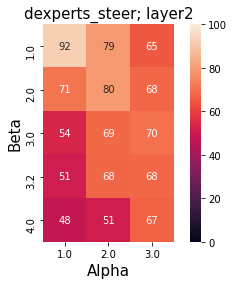

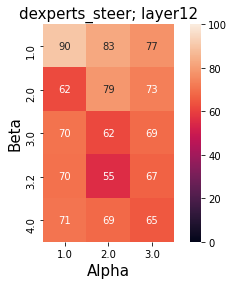

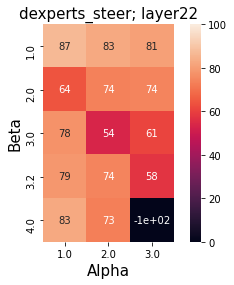

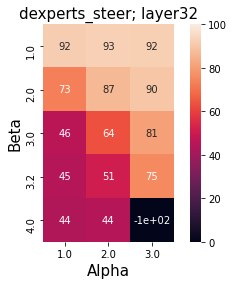

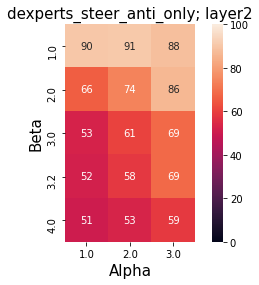

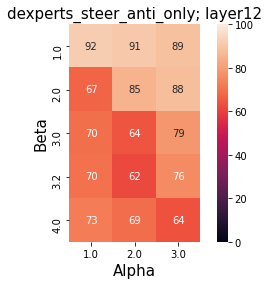

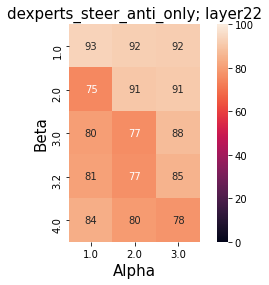

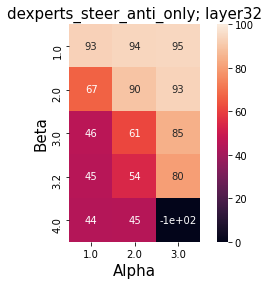

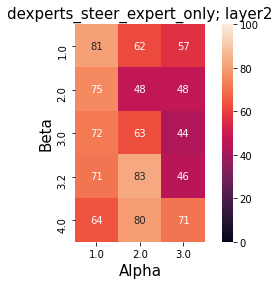

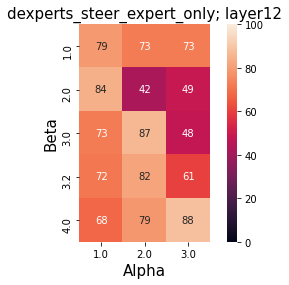

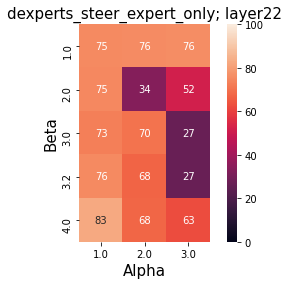

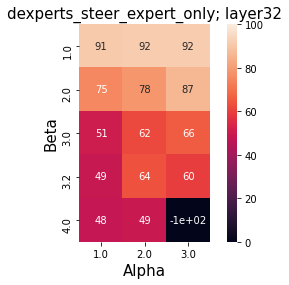

In [16]:
config_names, layer_nums, alpha_vals, beta_vals, pos_prompt_perfs = [], [], [], [], []
for model_name in negative_steering_res:
    config_name = model_name[:model_name.find('layer')-1]
    layer_num = model_name[model_name.find('layer')+5:].split('_')[0]
    alpha_val = model_name[model_name.find('alpha')+5:].split('_')[0]
    beta_val = model_name[model_name.find('beta')+4:].split('_')[0]
    pos_prompt_perf = negative_steering_res[model_name]['pos_prompts']
    #print(model_name)
    #print(layer_num)
    config_names.append(config_name)
    layer_nums.append(int(layer_num))
    alpha_vals.append(float(alpha_val))
    beta_vals.append(float(beta_val))
    pos_prompt_perfs.append(pos_prompt_perf)


new_result_df = pd.DataFrame(list(zip(config_names, layer_nums, alpha_vals, beta_vals, pos_prompt_perfs)),
                             columns =['config name', 'layer', 'alpha', 'beta', 'percent positive (lower better)'])

layer_nums = [2, 12, 22, 32]
for config in ['dexperts_steer', 'dexperts_steer_anti_only', 'dexperts_steer_expert_only']:
    for layer_num in [2, 12, 22, 32]:
        filtered_df = new_result_df[new_result_df['config name'] == config]
        curr_df = filtered_df[filtered_df['layer'] == layer_num]# and new_result_df['layer'] == 22)

        curr_mat = curr_df['percent positive (lower better)'].to_numpy().reshape(3, -1)
        #print(curr_mat)
        #new_result_df[new_result_df[new_result_df['config name'] == 'dexperts_steer']['layer'] == 22]
        ax = sns.heatmap(curr_mat.transpose(), 
                    xticklabels=[1.0, 2.0, 3.0], 
                    yticklabels=[1.0, 2.0, 3.0, 3.2, 4.0], 
                    vmin=0, 
                    vmax=100, 
                    square=True, 
                    annot=True)
        plt.title(f'{config}; layer{layer_num}', fontsize=15) # title with fontsize 20
        plt.xlabel('Alpha', fontsize = 15) # x-axis label with fontsize 15
        plt.ylabel('Beta', fontsize = 15) # y-axis label with fontsize 15

        plt.show()
#s.set(xlabel='bet', ylabel='Y-Axis')

In [14]:
'''
Evaluate the following

expert_only layer 32; alpha 1.0, beta 4.0
expert_only layer 22; alpha 3.0, beta 3.0
expert_only layer 22; alpha 2.0, beta 2.0
antiexpert_only layer 32; alpha 1.0, beta 4.0
dexperts steer layer 32; alpha 1.0, beta 4.0
'''

POS_DIR = Path('../generations/sentiment/positive_prompts/')

# alphas = [1.0, 2.0, 3.0]
# betas = [1.0, 2.0, 3.0, 3.2, 4.0]
# layer_nums = [2, 12, 22, 32]
# configs = ['dexperts_steer', 'dexperts_steer_anti_only', 'dexperts_steer_expert_only']

final_evaluated_models = {
    'dexperts_steer_expert_only_layer32_alpha1.0_beta4.0': {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer_expert_only/steering_large_gpt2/alpha_1.0_beta_4.0/layer_32_freeze_emb_lm_head_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl'
    },
    'dexperts_steer_expert_only_layer22_alpha3.0_beta3.0': {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer_expert_only/steering_large_gpt2/alpha_3.0_beta_3.0/layer_22_freeze_emb_lm_head_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl'
    },
    'dexperts_steer_expert_only_layer22_alpha2.0_beta2.0': {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer_expert_only/steering_large_gpt2/alpha_2.0_beta_2.0/layer_22_freeze_emb_lm_head_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl'
    },
    'dexperts_steer_anti_only_layer32_alpha1.0_beta4.0': {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_1.0_beta_4.0/layer_32_freeze_emb_lm_head_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl'
    },
    'dexperts_steer_layer32_alpha1.0_beta4.0': {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_1.0_beta_4.0/layer_32_freeze_emb_lm_head_with_expert_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl'
    },
}

final_pos_prompts_res = read_sentiment_results({m: p['pos_path'] for m,p in final_evaluated_models.items()}, auto_eval=True)
    
final_negative_steering_res = {}

for model in final_pos_prompts_res.keys():
    final_negative_steering_res[model] = {
        #'neutral_prompts': neutral_prompts_res[model]['positive_proportion']*100,
        'pos_prompts': final_pos_prompts_res[model]['positive_proportion']*100,
        'dist-1': final_pos_prompts_res[model]['dist-1'],
        'dist-2': final_pos_prompts_res[model]['dist-2'],
        'dist-3': final_pos_prompts_res[model]['dist-3'],
        'perplexity': final_pos_prompts_res[model]['perplexity'],
#         'dist-1': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-1'),
#         'dist-2': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-2'),
#         'dist-3': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-3'),
#         'perplexity': weighted_average(neutral_prompts_res, pos_prompts_res, 'perplexity'),
    }
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame(final_negative_steering_res).transpose().sort_values(by='pos_prompts', ascending=False).round(2))


100%|██████████| 5/5 [00:00<00:00,  6.00it/s]


,pos_prompts,dist-1,dist-2,dist-3,perplexity
dexperts_steer_expert_only_layer32_alpha1.0_beta4.0,48.31,0.96,0.92,0.83,NaN
dexperts_steer_anti_only_layer32_alpha1.0_beta4.0,44.30,0.98,0.92,0.84,NaN
dexperts_steer_layer32_alpha1.0_beta4.0,43.53,0.97,0.92,0.84,NaN
dexperts_steer_expert_only_layer22_alpha2.0_beta2.0,33.56,0.65,0.86,0.83,202.77
dexperts_steer_expert_only_layer22_alpha3.0_beta3.0,26.74,0.68,0.86,0.81,759.10


In [19]:
test_str = "dexperts_steer_layer2_alpha1.0_beta1.0"
config_name = test_str[:test_str.find('layer')-1]
layer_num = test_str[test_str.find('layer')+5:].split('_')[0]
alpha_val = test_str[test_str.find('alpha')+5:].split('_')[0]
beta_val = test_str[test_str.find('beta')+4:].split('_')[0]
print(config_name)
print(layer_num)
print(alpha_val)
print(beta_val)

dexperts_steer
2
1.0
1.0


In [12]:
# results corresponding to the bottom  half of Table 3

NEUTRAL_DIR = Path('../generations/sentiment/neutral_prompts/')
POS_DIR = Path('../generations/sentiment/positive_prompts/')

models = {
    'Layer 24 (anti-only)': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
    },
    'Layer 24': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
    },
    'Layer 24 combine at logit': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert/combine_at_logit/prompted_gens_dexperts.jsonl',
    }
}

#neutral_prompts_res = read_sentiment_results({m: p['neutral_path'] for m,p in models.items()})
pos_prompts_res = read_sentiment_results({m: p['pos_path'] for m,p in models.items()})

100%|██████████| 3/3 [00:00<00:00,  6.64it/s]


In [13]:
negative_steering_res = {}
assert set(neutral_prompts_res.keys()) == set(pos_prompts_res.keys())
for model in neutral_prompts_res.keys():
    negative_steering_res[model] = {
        #'neutral_prompts': neutral_prompts_res[model]['positive_proportion']*100,
        'pos_prompts': pos_prompts_res[model]['positive_proportion']*100,
#         'dist-1': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-1'),
#         'dist-2': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-2'),
#         'dist-3': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-3'),
#         'perplexity': weighted_average(neutral_prompts_res, pos_prompts_res, 'perplexity'),
    }
pd.DataFrame(negative_steering_res).transpose().sort_values(by='neutral_prompts', ascending=False).round(2)

,neutral_prompts,pos_prompts
Layer 24 (anti-only),42.61,91.05
Layer 24,36.19,90.71
Layer 24 combine at logit,36.19,91.46


In [14]:
### Alpha experiment, I think fluency is really bad for high alphas and make less logical sense on viewing some of the generations.

In [15]:
# results corresponding to the bottom  half of Table 3

POS_DIR = Path('../generations/sentiment/positive_prompts/')

models = {}
for alpha in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.2, 3.5, 4.0, 5.0, 10.0, 20.0, 30.0]:
    models[f'Layer_24_alpha_{alpha}'] = {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_{alpha}/layer_24_freeze_emb_lm_head_with_expert/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
    }

pos_prompts_res = read_sentiment_results({m: p['pos_path'] for m,p in models.items()})
negative_steering_res = {}
#assert set(neutral_prompts_res.keys()) == set(pos_prompts_res.keys())
for model in pos_prompts_res.keys():
    negative_steering_res[model] = {
        #'neutral_prompts': neutral_prompts_res[model]['positive_proportion']*100,
        'pos_prompts': pos_prompts_res[model]['positive_proportion']*100,
#         'dist-1': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-1'),
#         'dist-2': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-2'),
#         'dist-3': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-3'),
#         'perplexity': weighted_average(neutral_prompts_res, pos_prompts_res, 'perplexity'),
    }
pd.DataFrame(negative_steering_res).transpose().sort_values(by='pos_prompts', ascending=False).round(2)

100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


,pos_prompts
Layer_24_alpha_0.5,94.64
Layer_24_alpha_1.0,93.97
Layer_24_alpha_1.5,93.32
Layer_24_alpha_2.0,92.59
Layer_24_alpha_2.5,91.89
Layer_24_alpha_3.0,91.09
Layer_24_alpha_3.2,90.71
Layer_24_alpha_3.5,90.25
Layer_24_alpha_4.0,89.40
Layer_24_alpha_5.0,87.35


In [4]:
from typing import Dict
def return_perplexity_of_sentiment_model(models_dict: Dict[str, str]):
    res = {}
    for model in tqdm(models_dict):
        path_to_model = models_dict[model]
        if path_to_model == 'None':
            res[model] = {'ppl': -1}
        else:
            with open(os.path.join(path_to_model, 'eval_results_lm.txt')) as f:
                for line in f:
                    res[model] = {'ppl': float(line.split(' = ')[1])}
                    break
    return res
    

In [35]:
## Different Language Model experiments

# results corresponding to the bottom  half of Table 3

POS_DIR = Path('../generations/sentiment/positive_prompts/')
model_dir = '../models/experts/sentiment/'
source_sentiment = 'positive'
target_sentiment = 'negative'

models = {
    'DExperts (anti-only)': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_anti_only/prompted_gens_dexperts.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_anti_only/prompted_gens_dexperts.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}",
        'expert_ppl_path': 'None',
    },
    'DExperts (large)': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts/prompted_gens_dexperts.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts/prompted_gens_dexperts.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}",
        'expert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{target_sentiment}",
    },
    'DExperts small experts (anti-only)': {
        #'neutral_path': NEUTRAL_DIR / 'small_experts/negative/dexperts_anti_only/prompted_gens_dexperts.jsonl',
        'pos_path': POS_DIR / 'small_experts/negative/dexperts_anti_only/prompted_gens_dexperts.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/small/finetuned_gpt2_{source_sentiment}",
        'expert_ppl_path': 'None',
    },
    'DExperts small experts': {
        #'neutral_path': NEUTRAL_DIR / 'small_experts/negative/dexperts/prompted_gens_dexperts.jsonl',
        'pos_path': POS_DIR / 'small_experts/negative/dexperts/prompted_gens_dexperts.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/small/finetuned_gpt2_{source_sentiment}",
        'expert_ppl_path': f"{model_dir}/small/finetuned_gpt2_{target_sentiment}",
    },
    'Layer 24 (anti-only) 3 epochs': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24",
        'expert_ppl_path': 'None',
    },
    'Layer 24 3 epochs': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24",
        'expert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24",
    },
    'Layer 24 (anti-only) 50 epochs': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_epochs50/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24_50",
        'expert_ppl_path': 'None',
    },
    'Layer 24 50 epochs': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert_epochs50/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24_50",
        'expert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24_50",
    },
    'Layer 24 (anti-only) 100 epochs': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_epochs100/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24_100",
        'expert_ppl_path': 'None',
    },
    'Layer 24 100 epochs': {
        #'neutral_path': NEUTRAL_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'pos_path': POS_DIR / 'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_24_freeze_emb_lm_head_with_expert_epochs100/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'antiexpert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24_100",
        'expert_ppl_path': f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24_100",
    }
}

# read sentiment control results
pos_prompts_res = read_sentiment_results({m: p['pos_path'] for m,p in models.items()})
antiexpert_ppl_res = return_perplexity_of_sentiment_model({m: p['antiexpert_ppl_path'] for m,p in models.items()})
expert_ppl_res = return_perplexity_of_sentiment_model({m: p['expert_ppl_path'] for m,p in models.items()})

negative_steering_res = {}
for model in pos_prompts_res.keys():
    negative_steering_res[model] = {
        'pos_prompts': pos_prompts_res[model]['positive_proportion']*100,
        'antiexpert_ppl': antiexpert_ppl_res[model]['ppl'],
        'expert_ppl': expert_ppl_res[model]['ppl'],
    }
    
pd.DataFrame(negative_steering_res).transpose().sort_values(by='pos_prompts', ascending=False).round(2)



100%|██████████| 10/10 [00:00<00:00, 24892.01it/s]


,pos_prompts,antiexpert_ppl,expert_ppl
DExperts (anti-only),92.29,18.81,-1.00
Layer 24 (anti-only) 3 epochs,91.05,42.09,-1.00
DExperts small experts (anti-only),90.93,40.04,-1.00
Layer 24 3 epochs,90.71,42.09,43.80
Layer 24 100 epochs,68.21,7.69,7.20
Layer 24 50 epochs,64.32,18.01,17.93
Layer 24 (anti-only) 100 epochs,56.00,7.69,-1.00
DExperts small experts,46.55,40.04,41.09
Layer 24 (anti-only) 50 epochs,40.44,18.01,-1.00
DExperts (large),33.95,18.81,18.58


{'ppl': 7.69039240771082}

In [ ]:
#pos -> neg
model_dir = '../models/experts/sentiment/'
source_sentiment = 'positive'
target_sentiment = 'negative'
model_path_to_expert_ppls = {
    'DExperts (anti-only)': 'None'#f"{model_dir}/large/finetuned_gpt2_{target_sentiment}",
    'Layer 24 (anti-only) 3 epochs': 'None'#f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24",
    'DExperts small experts (anti-only)': 'None'#f"{model_dir}/small/finetuned_gpt2_{target_sentiment}",
    'Layer 24 3 epochs': f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24",
    'Layer 24 100 epochs': f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24_50",
    'Layer 24 50 epochs': f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24_100",
    'Layer 24 (anti-only) 100 epochs': 'None'#f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24_100",
    'DExperts small experts': f"{model_dir}/small/finetuned_gpt2_{target_sentiment}",
    'Layer 24 (anti-only) 50 epochs': 'None',#f"{model_dir}/large/finetuned_gpt2_{target_sentiment}_experimental_freeze_emb_and_lmhead_layers24_50",
    'DExperts (large)': f"{model_dir}/large/finetuned_gpt2_{target_sentiment}",
}

model_path_to_antiexpert_ppls = {
    'DExperts (anti-only)': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}",
    'Layer 24 (anti-only) 3 epochs': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24",
    'DExperts small experts (anti-only)': f"{model_dir}/small/finetuned_gpt2_{source_sentiment}",
    'Layer 24 3 epochs': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24",
    'Layer 24 100 epochs': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24_50",
    'Layer 24 50 epochs': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24_100",
    'Layer 24 (anti-only) 100 epochs': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24_100",
    'DExperts small experts': f"{model_dir}/small/finetuned_gpt2_{source_sentiment}",
    'Layer 24 (anti-only) 50 epochs': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}_experimental_freeze_emb_and_lmhead_layers24_50",
    'DExperts (large)': f"{model_dir}/large/finetuned_gpt2_{source_sentiment}",
}

pos_prompts_expert_ppl_res = return_perplexity_of_sentiment_model({m: p['pos_path'] for m,p in models.items()})

negative_steering_res = {}
for model in pos_prompts_res.keys():
    negative_steering_res[model] = {
        'pos_prompts': pos_prompts_res[model]['positive_proportion']*100,
    }
    
pd.DataFrame(negative_steering_res).transpose().sort_values(by='pos_prompts', ascending=False).round(2)



In [5]:
from typing import Dict
def return_perplexity_of_sentiment_model(models_dict: Dict[str, str]):
    res = {}
    for model in tqdm(models_dict):
        path_to_model = models_dict[model]
        if path_to_model == 'None':
            res[model] = {'ppl': -1}
        else:
            with open(os.path.join(path_to_model, 'eval_results_lm.txt')) as f:
                for line in f:
                    res[model] = {'ppl': float(line.split(' = ')[1])}
                    break
    return res


POS_DIR = Path('../generations/sentiment/positive_prompts/')
model_dir = '../models/experts/sentiment/'
source_sentiment = 'positive'
target_sentiment = 'negative'

models = {
    'GPT2 large': {
        'positive_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_positive_100_maxepochs',
        'negative_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_negative_100_maxepochs',
    },
    'GPT2 small': {
        'positive_path': f'{model_dir}/small/finetuned_gpt2_train_val_sst_positive_100_maxepochs',
        'negative_path': f'{model_dir}/small/finetuned_gpt2_train_val_sst_negative_100_maxepochs',
    }
}

for i in range(0, 36):
    models[f'layer{i}'] = {
        'positive_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_positive_experimental_freeze_emb_and_lmhead_layers{i}_100_maxepochs',
        'negative_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_negative_experimental_freeze_emb_and_lmhead_layers{i}_100_maxepochs',
    }

positive_ppl_res = return_perplexity_of_sentiment_model({m: p['positive_path'] for m,p in models.items()})
negative_ppl_res = return_perplexity_of_sentiment_model({m: p['negative_path'] for m,p in models.items()})

negative_steering_res = {}
for model in positive_ppl_res.keys():
    negative_steering_res[model] = {
        'positive_ppl': positive_ppl_res[model]['ppl'],
        'negative_ppl': negative_ppl_res[model]['ppl'],
    }
    
pd.DataFrame(negative_steering_res).transpose().round(2)



100%|██████████| 38/38 [00:00<00:00, 32362.14it/s]


,positive_ppl,negative_ppl
GPT2 large,31.35,30.51
GPT2 small,42.89,43.15
layer0,34.50,33.45
layer1,33.73,32.80
layer2,33.62,32.81
layer3,33.65,32.94
layer4,34.10,33.36
layer5,33.85,33.04
layer6,33.72,32.96
layer7,33.66,33.09


In [6]:
### New language models train_val_sst positive
# results corresponding to the bottom  half of Table 3

model_dir = '../models/experts/sentiment/'
POS_DIR = Path('../generations/sentiment/positive_prompts/')

models = {
    "DExperts Small" : {
        'pos_path': POS_DIR / f"small_experts/negative/dexperts/train_val_sst/prompted_gens_dexperts.jsonl",
        'positive_ppl_path': f'{model_dir}/small/finetuned_gpt2_train_val_sst_positive_100_maxepochs',
        'negative_ppl_path': f'{model_dir}/small/finetuned_gpt2_train_val_sst_negative_100_maxepochs',
    },
    "DExperts Small (anti-only)" : {
        'pos_path': POS_DIR / f"small_experts/negative/dexperts_anti_only/train_val_sst/prompted_gens_dexperts.jsonl",
        'positive_ppl_path': f'{model_dir}/small/finetuned_gpt2_train_val_sst_positive_100_maxepochs',
        'negative_ppl_path': 'None',
    },
    "DExperts Small (expert-only)" : {
        'pos_path': POS_DIR / f"small_experts/negative/dexperts_expert_only/train_val_sst/prompted_gens_dexperts.jsonl",
        'positive_ppl_path': 'None',
        'negative_ppl_path': f'{model_dir}/small/finetuned_gpt2_train_val_sst_negative_100_maxepochs',
    },
    "DExperts" : {
        'pos_path': POS_DIR / f"large_experts/negative/dexperts/train_val_sst/prompted_gens_dexperts.jsonl",
        'positive_ppl_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_positive_100_maxepochs',
        'negative_ppl_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_negative_100_maxepochs',
    },
    "DExperts (anti-only)" : {
        'pos_path': POS_DIR / f"large_experts/negative/dexperts_anti_only/train_val_sst/prompted_gens_dexperts.jsonl",
        'positive_ppl_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_positive_100_maxepochs',
        'negative_ppl_path': 'None',
    },
    "DExperts (expert-only)" : {
        'pos_path': POS_DIR / f"large_experts/negative/dexperts_expert_only/train_val_sst/prompted_gens_dexperts.jsonl",
        'positive_ppl_path': 'None', 
        'negative_ppl_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_negative_100_maxepochs',
    },
    
}

for layer_num in [2, 12, 22, 32]:
    models[f'Layer_{layer_num}'] = {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer/steering_large_gpt2/alpha_3.2/layer_{layer_num}_freeze_emb_lm_head_with_expert_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'positive_ppl_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_positive_experimental_freeze_emb_and_lmhead_layers{layer_num}_100_maxepochs',
        'negative_ppl_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_negative_experimental_freeze_emb_and_lmhead_layers{layer_num}_100_maxepochs',
    }
    
    models[f'Layer_{layer_num} (anti-only)'] = {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer_anti_only/steering_large_gpt2/alpha_3.2/layer_{layer_num}_freeze_emb_lm_head_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'positive_ppl_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_positive_experimental_freeze_emb_and_lmhead_layers{layer_num}_100_maxepochs',
        'negative_ppl_path': 'None',
    }
    
    models[f'Layer_{layer_num} (expert-only)'] = {
        'pos_path': POS_DIR / f'large_experts/negative/dexperts_steer_expert_only/steering_large_gpt2/alpha_3.2/layer_{layer_num}_freeze_emb_lm_head_epochs100_train_val_sst/combine_at_layer/prompted_gens_dexperts-steer.jsonl',
        'positive_ppl_path': 'None',
        'negative_ppl_path': f'{model_dir}/large/finetuned_gpt2_train_val_sst_negative_experimental_freeze_emb_and_lmhead_layers{layer_num}_100_maxepochs',
    }

pos_prompts_res = read_sentiment_results({m: p['pos_path'] for m,p in models.items()})
antiexpert_ppl_res = return_perplexity_of_sentiment_model({m: p['positive_ppl_path'] for m,p in models.items()})
expert_ppl_res = return_perplexity_of_sentiment_model({m: p['negative_ppl_path'] for m,p in models.items()})
negative_steering_res = {}
#assert set(neutral_prompts_res.keys()) == set(pos_prompts_res.keys())
for model in pos_prompts_res.keys():
    negative_steering_res[model] = {
        #'neutral_prompts': neutral_prompts_res[model]['positive_proportion']*100,
        'pos_prompts': pos_prompts_res[model]['positive_proportion']*100,
        'antiexpert_ppl': antiexpert_ppl_res[model]['ppl'],
        'expert_ppl': expert_ppl_res[model]['ppl'],
#         'dist-1': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-1'),
#         'dist-2': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-2'),
#         'dist-3': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-3'),
#         'perplexity': weighted_average(neutral_prompts_res, pos_prompts_res, 'perplexity'),
    }
pd.DataFrame(negative_steering_res).transpose().sort_values(by='pos_prompts', ascending=False).round(2)

100%|██████████| 18/18 [00:00<00:00, 23952.24it/s]


,pos_prompts,antiexpert_ppl,expert_ppl
DExperts Small (anti-only),90.92,42.89,-1.00
DExperts (anti-only),90.66,31.35,-1.00
Layer_22 (anti-only),86.86,34.61,-1.00
Layer_32 (anti-only),83.44,36.71,-1.00
Layer_32,78.99,36.71,36.98
Layer_12 (anti-only),77.67,34.23,-1.00
Layer_2,69.26,33.62,32.81
Layer_2 (anti-only),68.68,33.62,-1.00
Layer_12,67.75,34.23,33.93
Layer_32 (expert-only),63.69,-1.00,36.98
